# Problem statement

The idea is to forecast the mean of all COVID beds in the US for the upcoming year based on historical data gathered and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [119]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format
import pmdarima as pm

In [120]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [121]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs_29th_May_2020.csv')

# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2019-12-21       0.0000        0.0000        0.0000   
1   2       Abruzzo  2019-12-22       0.0000        0.0000        0.0000   
2   3       Abruzzo  2019-12-23       0.0000        0.0000        0.0000   
3   4       Abruzzo  2019-12-24       0.0000        0.0000        0.0000   
4   5       Abruzzo  2019-12-25       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  \
0       0.0000        0.0000        0.0000       0.0000  ...   
1       0.0000        0.0000        0.0000       0.0000  ...   
2       0.0000        0.0000        0.0000       0.0000  ...   
3       0.0000        0.0000        0.0000       0.0000  ...   
4       0.0000        0.0000        0.0000       0.0000  ...   

   totdea_lower_smoothed  totdea_upper_smoothed  mobility_data_type  \
0                    nan                    nan                 NaN   
1               

# Data Wrangling

* We're grouping by date and applying sum because we have data on states, and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all rows that have zeroes in mean, lower bound, and upper bound columns

In [122]:
data = data[['date', 'ICUbed_mean',  'ICUbed_lower',  'ICUbed_upper']] .groupby(['date']).sum().reset_index()
data = data[(data['ICUbed_mean']!=0) & (data['ICUbed_lower']!=0) & (data['ICUbed_upper']!=0)]

In [123]:
# Fetching only columns of interest
ICUBedData = data[['date', 'ICUbed_mean']]
ICUBedData.head()

,date,ICUbed_mean
44,2020-01-26,1.0000
45,2020-01-27,2.0000
46,2020-01-28,3.0000
47,2020-01-29,3.5266
48,2020-01-30,4.0514


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [124]:
ICUBedData['date'] = pd.to_datetime(ICUBedData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final All COVID beds value corresponding to each date.

### Grouping the column by date

In [125]:
ICUBedData = ICUBedData.groupby(['date']).sum().reset_index()
ICUBedData.iloc[0:50]

,date,ICUbed_mean
0,2020-01-26,1.0000
1,2020-01-27,2.0000
2,2020-01-28,3.0000
3,2020-01-29,3.5266
4,2020-01-30,4.0514
5,2020-01-31,4.5890
6,2020-02-01,3.5890
7,2020-02-02,2.5890
8,2020-02-03,1.5890
9,2020-02-04,1.5890


In [126]:
#setting index to date
ICUBedData = ICUBedData.set_index('date')
ICUBedData.index

DatetimeIndex(['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04',
               ...
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11'],
              dtype='datetime64[ns]', name='date', length=230, freq=None)

In [127]:
# importing datetime to fetch today's date
from datetime import datetime
today = datetime.now()
today = today.strftime("%Y-%m-%d")

In [128]:
# Keeping historical data till today
ICUBedData = ICUBedData[ICUBedData.index <= '2020-05-29']
ICUBedData.columns = ['value']
ICUBedData.tail()

,value
date,
2020-05-25,63526.8572
2020-05-26,63084.6088
2020-05-27,62683.9966
2020-05-28,62321.2996
2020-05-29,61971.2600


### Missing value analysis

We'll check is there's any missing value present in our data by applying isnull function on the dataset.

In [129]:
ICUBedData.isnull().any()

value    False
dtype: bool

Since, we get 'False' as the result, we can say that there are no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

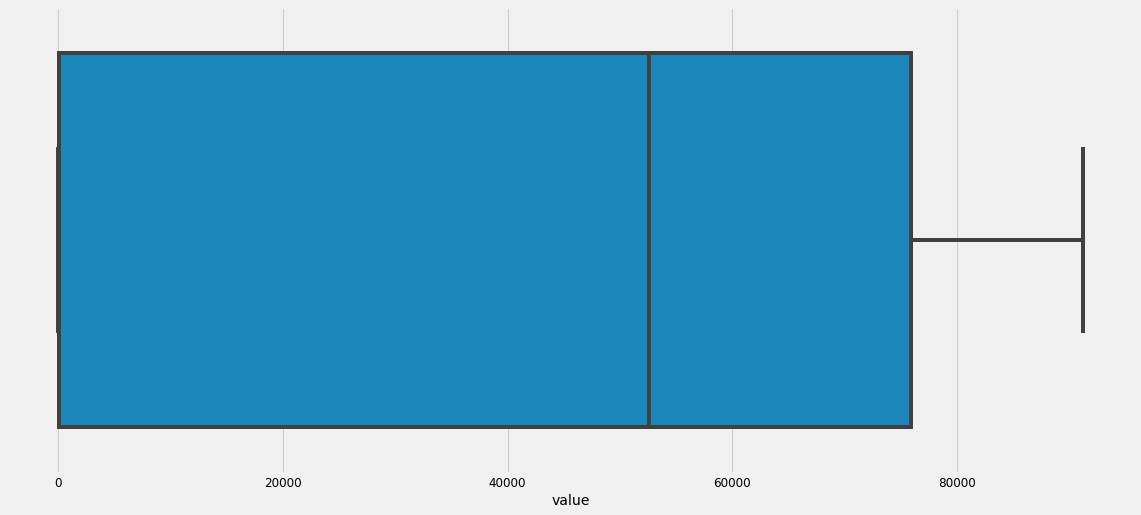

In [130]:
import seaborn as sns
sns.boxplot(x=ICUBedData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [131]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(ICUBedData))
print(z)

[[1.13903554]
 [1.13900815]
 [1.13898076]
 [1.13896634]
 [1.13895197]
 [1.13893724]
 [1.13896463]
 [1.13899202]
 [1.13901941]
 [1.13901941]
 [1.13885508]
 [1.13874552]
 [1.13869075]
 [1.13858809]
 [1.13855596]
 [1.13853999]
 [1.13870306]
 [1.13882699]
 [1.13889649]
 [1.13895127]
 [1.13895127]
 [1.13892388]
 [1.13889649]
 [1.1388691 ]
 [1.13883302]
 [1.13874226]
 [1.13867188]
 [1.13861326]
 [1.13849363]
 [1.13836391]
 [1.13813655]
 [1.13795847]
 [1.13583501]
 [1.13319205]
 [1.13011142]
 [1.12584232]
 [1.12063619]
 [1.11427924]
 [1.10797398]
 [1.10046903]
 [1.09119593]
 [1.08009341]
 [1.06699336]
 [1.05158322]
 [1.03445823]
 [1.00294185]
 [0.96706022]
 [0.92640728]
 [0.87811013]
 [0.82368626]
 [0.76270898]
 [0.70577071]
 [0.64293083]
 [0.57407624]
 [0.49873624]
 [0.41697902]
 [0.32882578]
 [0.23517111]
 [0.13568672]
 [0.03058302]
 [0.07894838]
 [0.18925503]
 [0.30179251]
 [0.41589394]
 [0.52961365]
 [0.64076049]
 [0.74810474]
 [0.84950696]
 [0.94408121]
 [1.02951774]
 [1.10472269]
 [1.16

As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [132]:
# Converting allBedData into time-series
ts = ICUBedData['value']
ts.head()

date
2020-01-26   1.0000
2020-01-27   2.0000
2020-01-28   3.0000
2020-01-29   3.5266
2020-01-30   4.0514
Name: value, dtype: float64

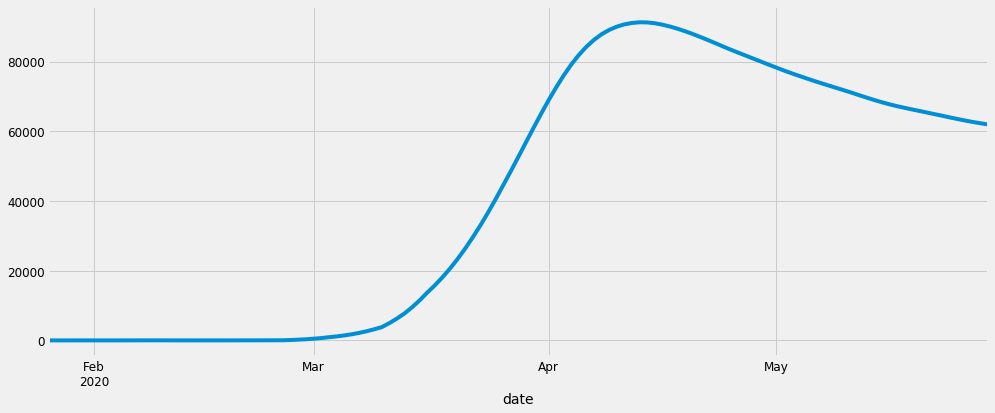

In [133]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increasing till mid-April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

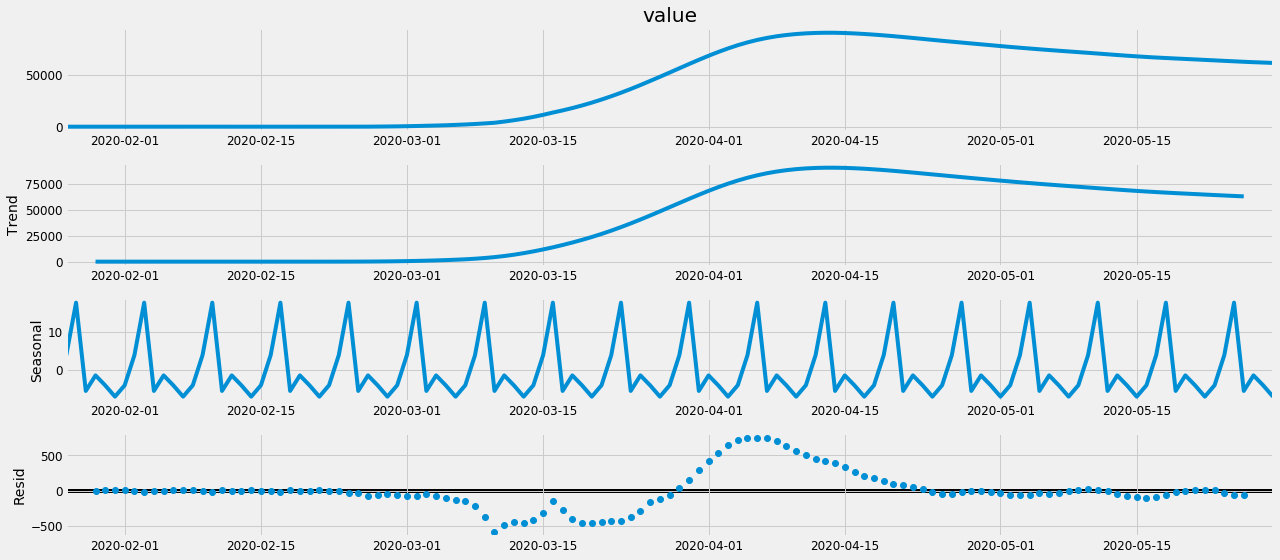

In [134]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking Stationarity

 In a time-series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [135]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

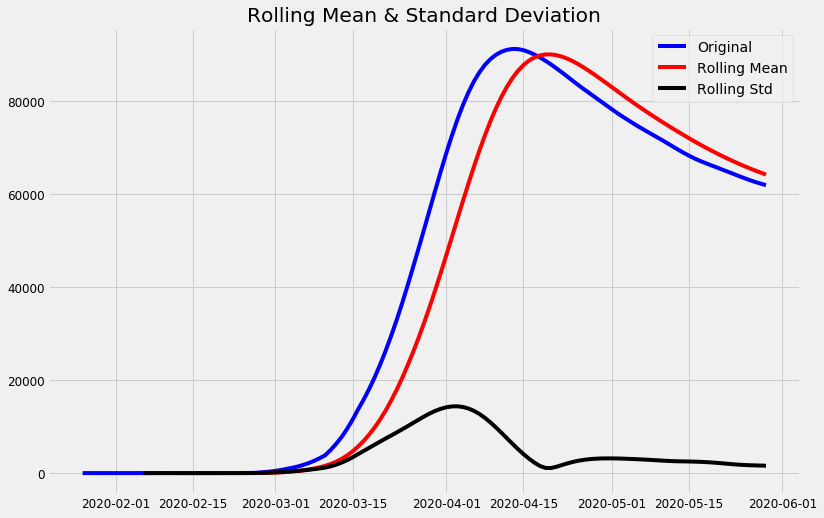

Results of Dickey-Fuller Test:
p-value = 0.4143. The series is likely non-stationary.
Test Statistic                 -1.7328
p-value                         0.4143
#Lags Used                     14.0000
Number of Observations Used   110.0000
Critical Value (1%)            -3.4912
Critical Value (5%)            -2.8882
Critical Value (10%)           -2.5810
dtype: float64


In [136]:
test_stationarity(ts)

We can see that this time-series is non-stationary with p value of 0.4143.

# Plotting ACF and PACF 

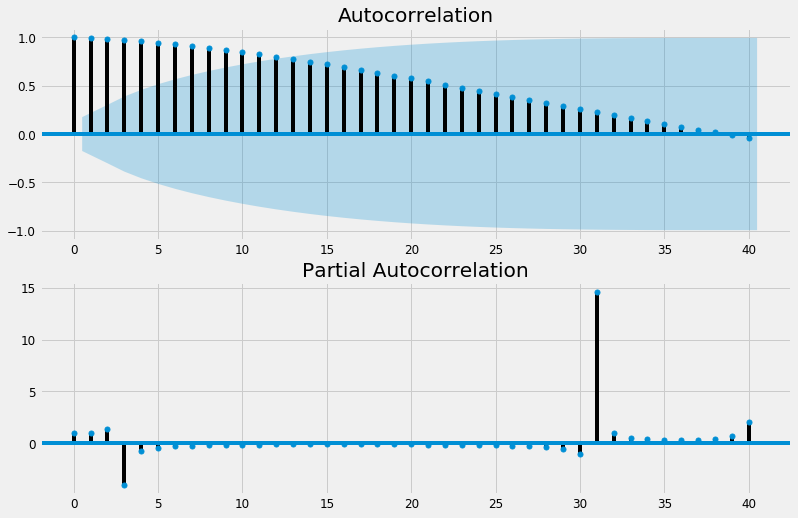

In [137]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 7 days, we're seeing some sine wave like pattern, let's consider SARIMA.

# Forecasting Time-Series with ARIMA

### Understanding ARIMA

ARIMA, an acronym for Autoregressive Integrated Moving Average, is a combination of two terms - (i) AR (ii) MA
* AR corresponds to the difference value. This is today's value minus yesterday's value or value-on-value change.
* MA corresponds to moving average terms.

Besides this, we have seen that there's high amount of seasonality in the time-series. Therefore, we will be using Seasonal ARIMA or SARIMA in this case.

# ARIMA

In [138]:
import pmdarima as pm

In [139]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
#pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for  ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[3]))
print('ARIMA: {}'.format(pdq[4]))

Examples of parameter combinations for  ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 2)
ARIMA: (0, 1, 0)
ARIMA: (0, 1, 1)


In [140]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [142]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
for x in pdq:
    try:
        #print(x)
        mod = ARIMA(ts, order =x)
        mod_fit = mod.fit()
        print('ARIMA{} - AIC:{}'.format(x, mod_fit.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:2985.083043319263
ARIMA(0, 1, 0) - AIC:2162.8386946027467
ARIMA(0, 2, 0) - AIC:1569.7384741090082
ARIMA(0, 2, 1) - AIC:1500.768098953073
ARIMA(0, 2, 2) - AIC:1460.1071466490478
ARIMA(1, 1, 1) - AIC:1518.6312264514695
ARIMA(1, 1, 2) - AIC:1477.822245520443
ARIMA(1, 2, 0) - AIC:1420.464673636567
ARIMA(1, 2, 1) - AIC:1403.7472837784296
ARIMA(1, 2, 2) - AIC:1401.3222435988591
ARIMA(2, 0, 1) - AIC:1523.1768962233846
ARIMA(2, 0, 2) - AIC:1489.5146114659738
ARIMA(2, 1, 1) - AIC:1410.3985415720767
ARIMA(2, 1, 2) - AIC:1409.2379231196035
ARIMA(2, 2, 0) - AIC:1402.7263988807301
ARIMA(2, 2, 1) - AIC:1403.3685006840096
ARIMA(2, 2, 2) - AIC:1396.9458444632103


We can see that (2, 2, 2) - AIC: 1396.9458 corresponds to the lowest AIC value of 1396.9458.

# Running diagnosis

In [143]:
mod = ARIMA(ts,order=(2, 2, 2))
                                
results = mod.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  123
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -692.473
Method:                       css-mle   S.D. of innovations             66.898
Date:                Sun, 14 Jun 2020   AIC                           1396.946
Time:                        22:06:25   BIC                           1413.819
Sample:                    01-28-2020   HQIC                          1403.800
                         - 05-29-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.9980     47.976     -0.021      0.983     -95.029      93.033
ar.L1.D2.value     1.4143      0.181      7.816      0.000       1.060       1.769
ar.L2.D2.value    -0.4729      0.168

In [146]:
m = pm.ARIMA(order=(2,2,2))
z = m.fit(ts)

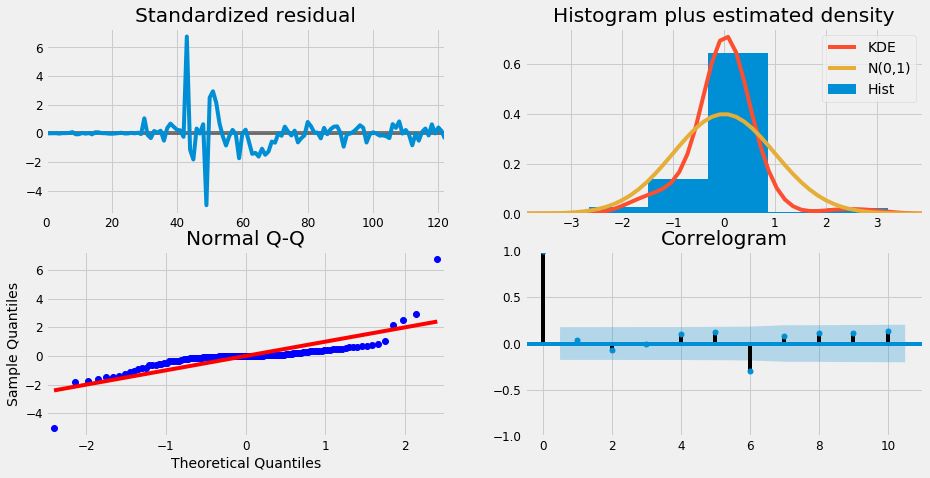

In [147]:
z.plot_diagnostics(figsize=(14, 7));

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

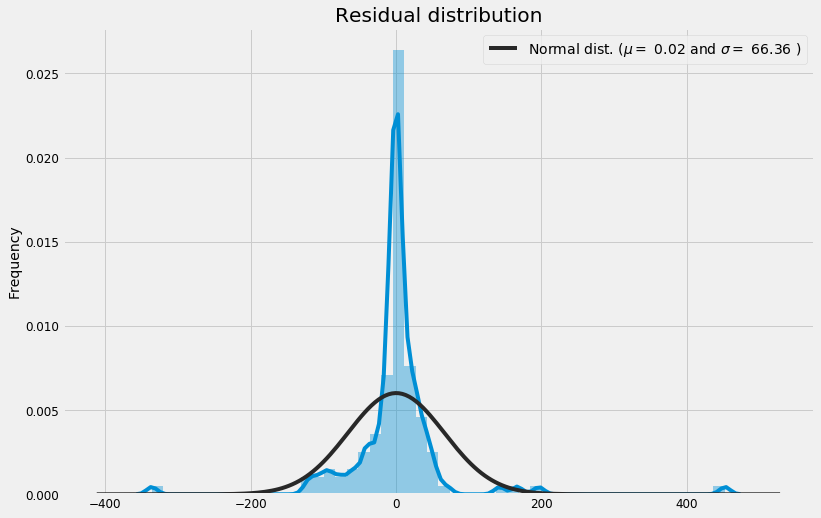

In [148]:
resid = z.resid()

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit= stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing 35th number in z.predict(len(ts)) (the 1st of March) as a reference point to start validating the forecasts.

In [149]:
z.predict(len(ts))

array([61652.90511639, 61359.69096846, 61086.99935091, 60831.39192131,
       60590.18877674, 60361.22489147, 60142.70490561, 59933.11289903,
       59731.1534329 , 59535.710817  , 59345.81937168, 59160.64062306,
       58979.44510636, 58801.597409  , 58626.54361738, 58453.80063197,
       58282.94698838, 58113.6149256 , 57945.48350605, 57778.27263395,
       57611.73784701, 57445.66577726, 57279.87019285, 57114.18854515,
       56948.47895596, 56782.61758851, 56616.49635297, 56450.02090395,
       56283.10889272, 56115.68844168, 55947.69681292, 55779.07924597,
       55609.7879435 , 55439.78118584, 55269.0225582 , 55097.48027614,
       54925.12659679, 54751.9373049 , 54577.89126435, 54402.97002658,
       54227.15748885, 54050.43959599, 53872.80408   , 53694.24023285,
       53514.73870805, 53334.2913476 , 53152.89103083, 52970.53154249,
       52787.20745762, 52602.91404111, 52417.64715991, 52231.40320653,
       52044.17903217, 51855.97188845, 51666.77937642, 51476.5994022 ,
      

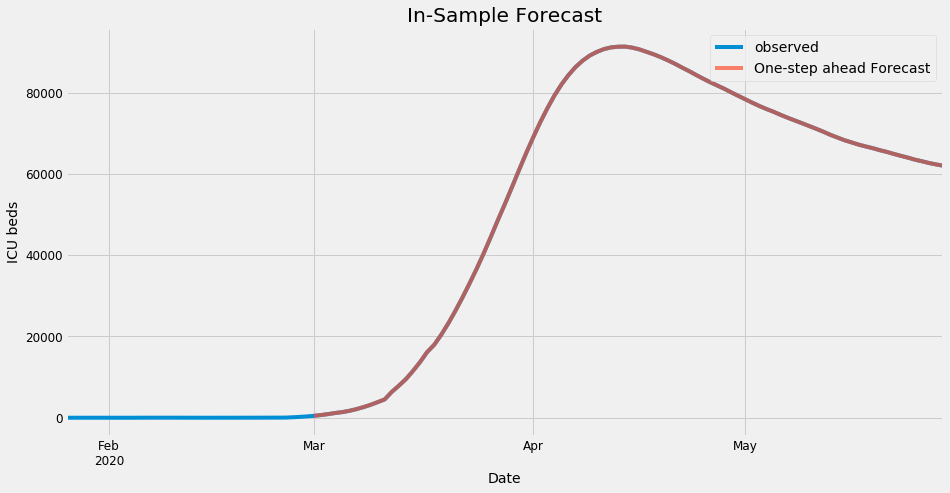

In [150]:
pred_int = z.predict_in_sample(start = 35, return_conf_int=True, alpha = 0.05)
df_pred = ICUBedData[35:]
df_pred['value'] = pred_int[0]
ts_pred = df_pred['value']
ax = ts.plot(label='observed')
ts_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('ICU beds')
plt.title('In-Sample Forecast')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [151]:
ts_truth = ts['2020-04-01':]
df_pred = ICUBedData[len(ts_truth):]
pred_int = z.predict_in_sample(start = len(ts_truth), return_conf_int=True, alpha = 0.05)
df_pred['value'] = pred_int[0]
ts_forecasted = df_pred['value']
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [152]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [153]:
ts.min()

1.0

In [154]:
ts.max()

91307.25253159771

This means that the value of RMSE is 0.0. Also, the minimum and maximum values of time series is 1.0 and 91307.25253159771 respectively. Overall, this is a very good model so far.

# Visualizing Forecast

In [155]:
from datetime import date, timedelta, datetime
next_100_days = []
datetime_str = '2020-05-29'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d')
for j in range(1, 101, 1):
        next_100_days.append((datetime_object + timedelta(days=j)).date())

In [156]:
next_100_days[0:6]

[datetime.date(2020, 5, 30),
 datetime.date(2020, 5, 31),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 4)]

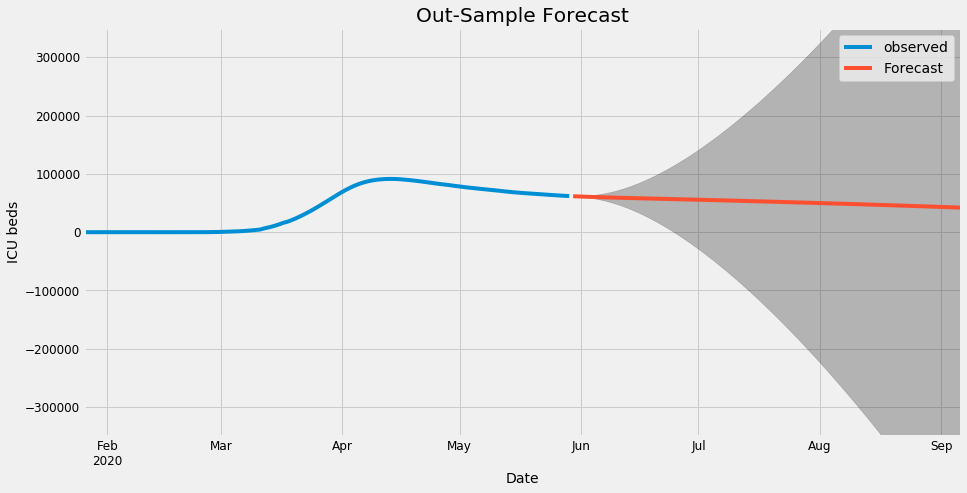

In [157]:
# Using the default confidence interval - 95%
pred_uc = z.predict(100, return_conf_int=True, alpha = 0.05)
pred_ci = pred_uc[0]

df_ci = pd.DataFrame(columns=['date', 'predicted_mean', 'lower', 'upper'])
df_ci['predicted_mean'] = pred_uc[0]
df_ci['date'] = next_100_days
df_ci['lower'] = pred_uc[1][:,0]
df_ci['upper'] = pred_uc[1][:,1]
df_ci['date'] = pd.to_datetime(df_ci['date'])
df_ci = df_ci.set_index('date')


# df_ci_2['date'] = next_100_days
# df_ci_2 = df_ci_2.set_index('date')
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('ICU beds')
plt.title('Out-Sample Forecast')
plt.ylim([-350000, 350000])
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [158]:
df_ci.head()

,predicted_mean,lower,upper
date,,,
2020-05-30,61652.9051,61521.7558,61784.0544
2020-05-31,61359.6910,61021.2137,61698.1682
2020-06-01,61086.9994,60423.3672,61750.6315
2020-06-02,60831.3919,59700.0143,61962.7695
2020-06-03,60590.1888,58830.6512,62349.7263


In [159]:
# Setting all negative forecasted values to be 0
df_ci.predicted_mean[df_ci.predicted_mean < 0] = 0
df_ci.predicted_mean

date
2020-05-30   61652.9051
2020-05-31   61359.6910
2020-06-01   61086.9994
2020-06-02   60831.3919
2020-06-03   60590.1888
                ...    
2020-09-02   43051.1676
2020-09-03   42820.0106
2020-09-04   42587.8519
2020-09-05   42354.6914
2020-09-06   42120.5291
Name: predicted_mean, Length: 100, dtype: float64

In [160]:
df_ci['lower'][df_ci['lower'] < 0] = 0
df_ci['upper'][df_ci['upper'] < 0] = 0
df_ci

,predicted_mean,lower,upper
date,,,
2020-05-30,61652.9051,61521.7558,61784.0544
2020-05-31,61359.6910,61021.2137,61698.1682
2020-06-01,61086.9994,60423.3672,61750.6315
2020-06-02,60831.3919,59700.0143,61962.7695
2020-06-03,60590.1888,58830.6512,62349.7263
...,...,...,...
2020-09-02,43051.1676,0.0000,578273.1345
2020-09-03,42820.0106,0.0000,587135.7923
2020-09-04,42587.8519,0.0000,596048.6759


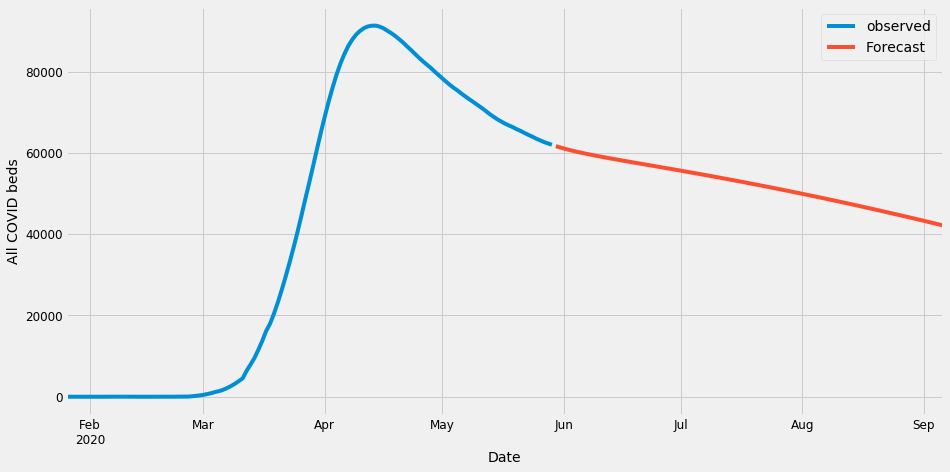

In [161]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

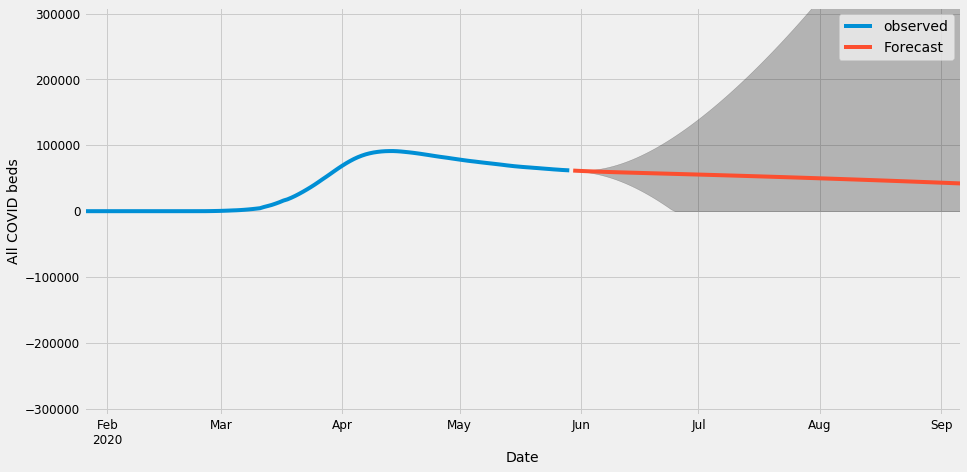

In [162]:
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

In [163]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':df_ci.predicted_mean, 
                                   'Predicted lower value':df_ci.iloc[:, 1], 
                                  'Predicted upper value': df_ci.iloc[:, 2]})

In [164]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
date,,,
2020-05-30,61652.9051,61521.7558,61784.0544
2020-05-31,61359.6910,61021.2137,61698.1682
2020-06-01,61086.9994,60423.3672,61750.6315
2020-06-02,60831.3919,59700.0143,61962.7695
2020-06-03,60590.1888,58830.6512,62349.7263
2020-06-04,60361.2249,57801.4013,62921.0485
2020-06-05,60142.7049,56603.5098,63681.9000
2020-06-06,59933.1129,55232.0191,64634.2067
2020-06-07,59731.1534,53684.7343,65777.5726


# Forecasting Time-Series with SARIMA

In [165]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


This step is parameter selection for our SARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Parameters corresponding to lowest AIC are the ones that we'd choose.

In [166]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3063.4021425660385
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2714.9755377649176
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2443.7956312497677
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2523.60603613717
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2364.2147058889454
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1908.0985263379698
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2238.14051089459
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1956.5053936501954
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1674.0537956848796
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2546.1690764343725
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2471.5369515688485
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:2168.368136326497
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2239.057247470628
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2186.4556604336485
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1900.7091040666446
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1996.6717927521347
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1952.9194700326202
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC

SARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:1655.8654206426784
SARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:1488.7417392982675
SARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:1581.4683146249906
SARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1516.7343837873661
SARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:1325.7925587371406
SARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:1438.613261930366
SARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:1364.0535353047835
SARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:1192.1598722932547
SARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:1541.8067297902735
SARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:1527.0110861849205
SARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:1490.305326631148
SARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1377.9085580812748
SARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1397.5434755223746
SARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1326.4062135708452
SARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:1238.259253763631
SARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:1217.5676878355112
SARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:1181.0341370052727
SARIMA(0, 2, 0)x(0, 0, 0, 12)12 - 

SARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:1667.3105983621622
SARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:1437.2581222166496
SARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:1483.7529386820947
SARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:1469.8869865281847
SARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:1288.9942297795017
SARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:1326.2095026769173
SARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1256.3994784175732
SARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:1894.167223797332
SARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1692.780859440267
SARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:1642.0629454378623
SARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1712.8745939368605
SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1553.6168378793561
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1424.187519329045
SARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:1597.2264847962538
SARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1380.3797524270715
SARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1278.9158535035126
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1716.39554423673
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AI

SARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:1319.6639275488155
SARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:1171.8340597469382
SARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:1480.7376211159199
SARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:1236.9773554060246
SARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:1032.0395339913293
SARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:1464.7615260836815
SARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:1454.3648920605524
SARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:1302.078124703682
SARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:1365.968014382093
SARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1320.9177255680693
SARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:1165.2286766287007
SARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:1279.9229663863239
SARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:1220.1018125201454
SARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1033.9648302984401
SARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:1317.627159573329
SARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:1313.7293546098122
SARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:1298.6311933069953
SARIMA(1, 2, 1)x(2, 1, 0, 12)12 - 

SARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:1208.0292546343665
SARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:1294.2681838196459
SARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1250.0842732022295
SARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:1086.843244806692
SARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:1335.5782397787436
SARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:1335.7528688851555
SARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:1330.8615698406993
SARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:1219.0889555184663
SARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:1218.0794145279842
SARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:1207.1596739147005
SARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:1094.388911722314
SARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:1072.15828399849
SARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:1068.0879434753333
SARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1604.9379741407295
SARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:1527.460494781509
SARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:1355.3850600474593
SARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:1536.5500528052635
SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AI

SARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:1055.2580658622253
SARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:1057.131096517586
SARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:1048.1295214998474


We can see that (1, 2, 2)x(1, 2, 2, 12)12 - AIC:1002.601 corresponds to the lowest AIC value of 1002.601.

# Fitting the SARIMA model

In [168]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  125
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood                -494.300
Date:                            Sun, 14 Jun 2020   AIC                           1002.601
Time:                                    23:20:22   BIC                           1018.537
Sample:                                01-26-2020   HQIC                          1008.945
                                     - 05-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9285      0.055     16.932      0.000       0.821       1.036
ma.L1         -1.0349      0.105   

We can see that the model has the following features: 

* kurtosis of 8.43, close to 0
* Jarque-Bera statistic of 124.35 (not close to zero) 
* All the above points mean that the model is close to normal distribution
* Also, AIC (1045.545) is not very low.

Thus, so far, we can see that statistics suggest we are having very good model.

# Running diagnosis

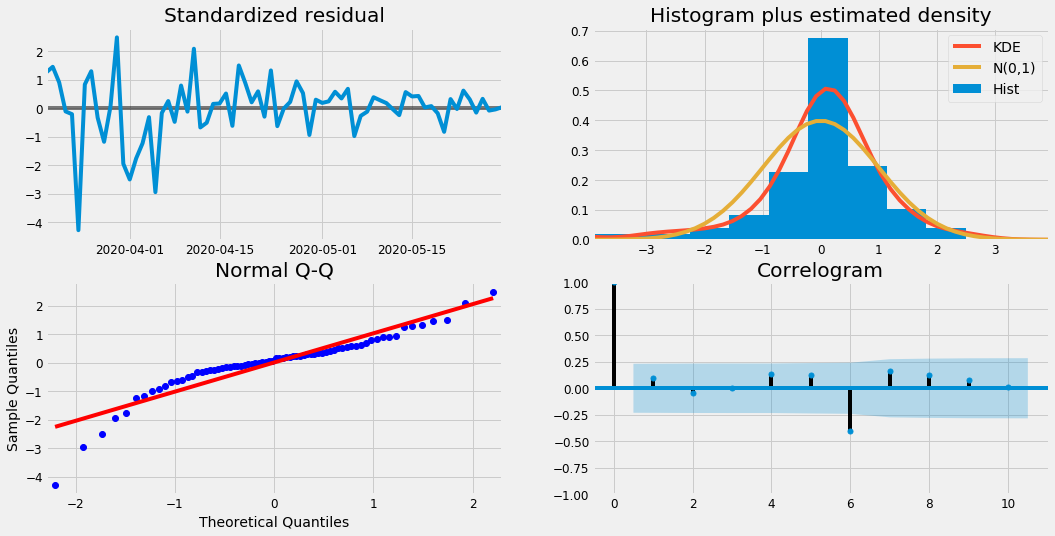

In [169]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

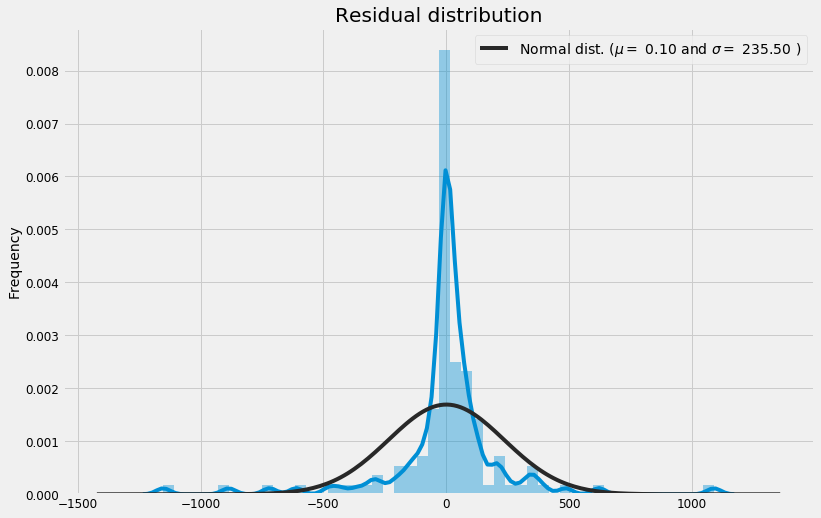

In [170]:
resid = results.resid

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing March as a reference point to start validating the forecasts.

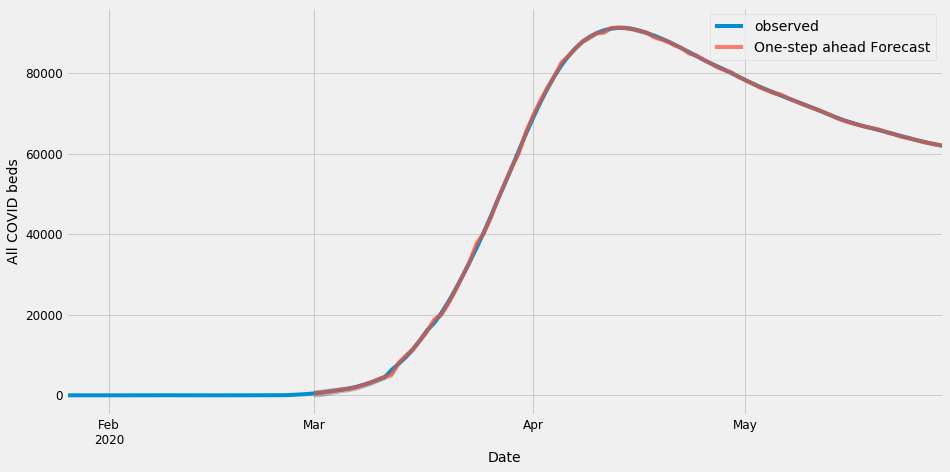

In [171]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [172]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2020-04-01':]
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36018.42


The MSE is very low.

In [173]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 189.79


In [174]:
ts.min()

1.0

In [175]:
ts.max()

91307.25253159771

This means that the value of RMSE is 189.79. Also, the minimum and maximum values of time series is 1.0 and 91307.25253159771 respectively. Overall, this is a very good model so far.

# Visualizing forecasts

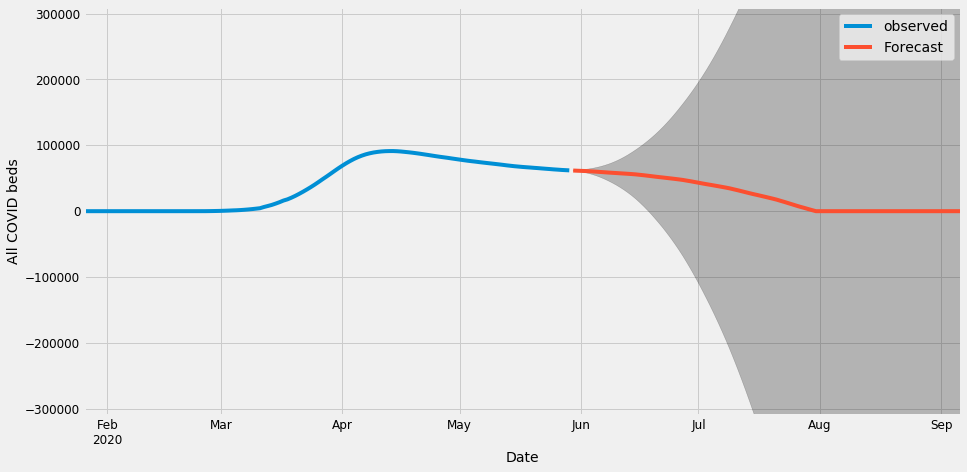

In [176]:
# Using the default confidence interval - 95%
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [177]:
# Setting all negative forecasted values to be 0
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean

2020-05-30   61707.2403
2020-05-31   61455.3217
2020-06-01   61227.2163
2020-06-02   60989.4923
2020-06-03   60709.6462
                ...    
2020-09-02       0.0000
2020-09-03       0.0000
2020-09-04       0.0000
2020-09-05       0.0000
2020-09-06       0.0000
Freq: D, Length: 100, dtype: float64

In [178]:
pred_ci['lower value'][pred_ci['lower value'] < 0] = 0
pred_ci['upper value'][pred_ci['upper value'] < 0] = 0
pred_ci

,lower value,upper value
2020-05-30,61313.1030,62101.3776
2020-05-31,60611.2076,62299.4358
2020-06-01,59740.6650,62713.7677
2020-06-02,58641.9473,63337.0373
2020-06-03,57267.1313,64152.1612
...,...,...
2020-09-02,0.0000,1716825.8723
2020-09-03,0.0000,1762398.7760
2020-09-04,0.0000,1808919.4226
2020-09-05,0.0000,1856320.7034


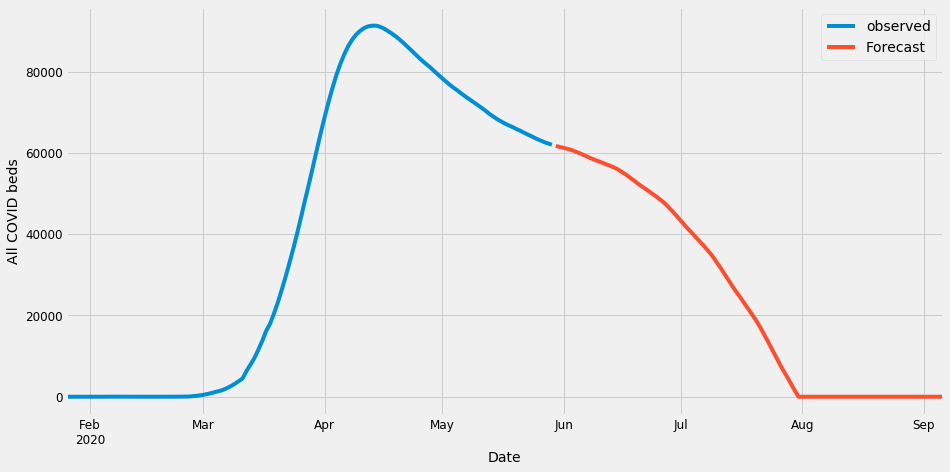

In [179]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

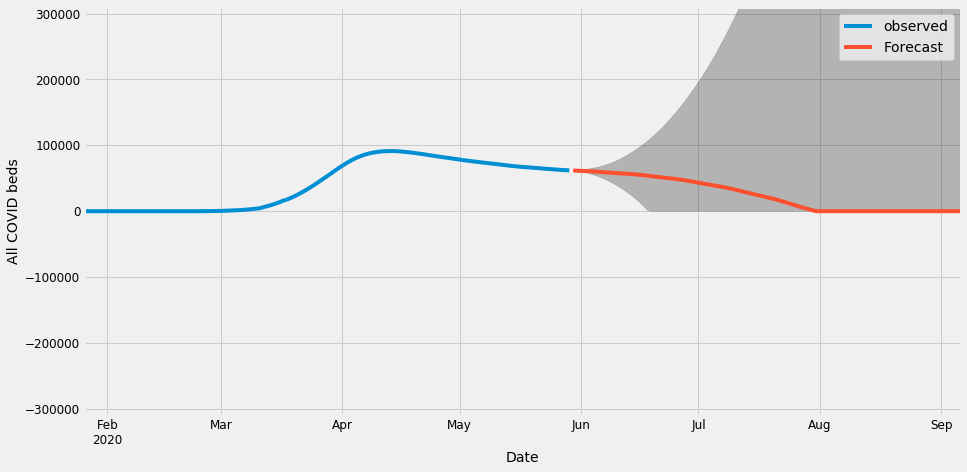

In [180]:
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.ylim([-310000, 310000])
plt.legend()
plt.show()

In [181]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':pred_uc.predicted_mean, 
                                   'Predicted lower value':pred_ci.iloc[:, 0], 
                                  'Predicted upper value': pred_ci.iloc[:, 1]})

In [182]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
2020-05-30,61707.2403,61313.1030,62101.3776
2020-05-31,61455.3217,60611.2076,62299.4358
2020-06-01,61227.2163,59740.6650,62713.7677
2020-06-02,60989.4923,58641.9473,63337.0373
2020-06-03,60709.6462,57267.1313,64152.1612
2020-06-04,60324.7260,55542.8136,65106.6383
2020-06-05,59954.0921,53581.0484,66327.1357
2020-06-06,59524.0630,51303.0832,67745.0428
2020-06-07,59105.8067,48778.2044,69433.4090
2020-06-08,58656.3468,45960.0214,71352.6722
